Using device : cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.92MB/s]


Epoch [1/10] | Loss: 0.5761 | Test Acc: 94.18%
Epoch [2/10] | Loss: 0.1534 | Test Acc: 96.20%
Epoch [3/10] | Loss: 0.1006 | Test Acc: 96.92%
Epoch [4/10] | Loss: 0.0797 | Test Acc: 97.47%
Epoch [5/10] | Loss: 0.0641 | Test Acc: 96.96%
Epoch [6/10] | Loss: 0.0542 | Test Acc: 97.66%
Epoch [7/10] | Loss: 0.0460 | Test Acc: 98.21%
Epoch [8/10] | Loss: 0.0425 | Test Acc: 98.16%
Epoch [9/10] | Loss: 0.0363 | Test Acc: 98.12%
Epoch [10/10] | Loss: 0.0323 | Test Acc: 98.45%


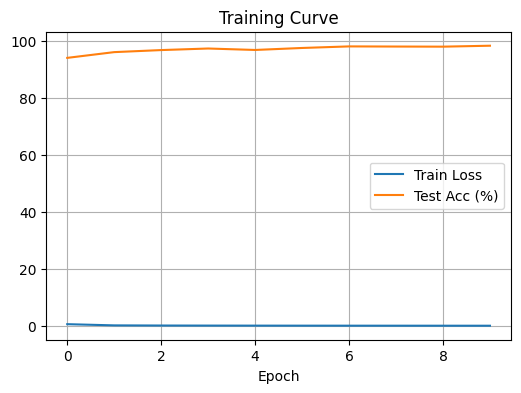

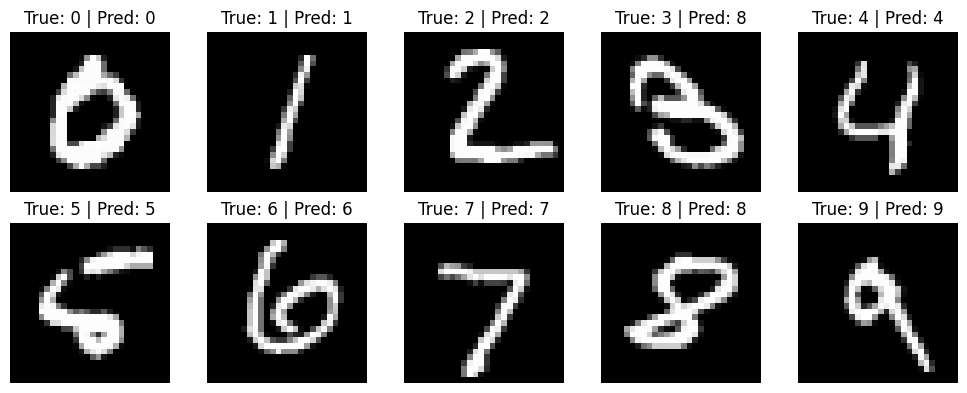

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# 固定亂數種子 → 讓結果可重現
SEED = 2025
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device :', device)

# ============================================================
# 1. Hyper-parameters（可自行微調）
# ============================================================

input_size   = 28      # 每一步的特徵數（取一列 28 像素）
hidden_size  = 128     # LSTM 隱藏層維度（↑ 準確率通常↑，但記憶體↑）
num_layers   = 1       # 本作業只需單層，照規格不調整
num_classes  = 10      # 0–9
batch_size   = 128
learning_rate= 0.001
num_epochs   = 10      # Colab 免費版 10 epoch 就能 >98 %

# ============================================================
# 2. 下載並載入 MNIST
# ============================================================

transform = transforms.ToTensor()

train_ds = torchvision.datasets.MNIST(root='./data', train=True,
                                      transform=transform, download=True)
test_ds  = torchvision.datasets.MNIST(root='./data', train=False,
                                      transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                           shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=batch_size,
                                           shuffle=False, num_workers=2, pin_memory=True)

# ============================================================
# 3. 手刻 LSTM Cell
# ============================================================

class ManualLSTMCell(nn.Module):
    """
    單一步驟的 LSTM：
    x_t shape : (batch, input_size)
    h_t,c_t    : (batch, hidden_size)
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        # 兩個 linear 分別處理 x_t 與 h_{t-1}，一次產生 4*hidden_size
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=True)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=True)

    def forward(self, x_t, h_prev, c_prev):
        # 合併線性變換
        gates = self.x2h(x_t) + self.h2h(h_prev)
        # Slice → i,f,o,g  (照順序拆張量)
        i_t, f_t, o_t, g_t = gates.chunk(4, dim=1)

        i_t = torch.sigmoid(i_t)          # input gate
        f_t = torch.sigmoid(f_t)          # forget gate
        o_t = torch.sigmoid(o_t)          # output gate
        g_t = torch.tanh(g_t)             # candidate cell

        c_t = f_t * c_prev + i_t * g_t    # 更新 cell state
        h_t = o_t * torch.tanh(c_t)       # 更新 hidden state
        return h_t, c_t

# ============================================================
# 3-2. 組成完整 LSTM 分類器
# ============================================================

class ManualLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.cell = ManualLSTMCell(input_size, hidden_size)
        self.fc   = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        x shape : (batch, 28, 28)
        逐列送入 LSTM → 最終 h_t 進全連接層
        """
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, hidden_size, device=x.device)

        for t in range(seq_len):                # 28 個 time steps
            x_t = x[:, t, :]                    # 取第 t 列，shape (batch, 28)
            h_t, c_t = self.cell(x_t, h_t, c_t)

        out = self.fc(h_t)                      # shape (batch, 10)
        return out

# ============================================================
# 4. 訓練 & 測試流程
# ============================================================

model     = ManualLSTMClassifier(input_size, hidden_size, num_classes).to(device)
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_acc_log = []

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images  = images.squeeze(1).to(device)      # (B,28,28)
        labels  = labels.to(device)

        outputs = model(images)
        loss    = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # =============== 測試迴圈 ===============
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.squeeze(1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    test_acc_log.append(acc)
    print(f'Epoch [{epoch}/{num_epochs}] | Loss: {epoch_loss:.4f} | Test Acc: {acc:.2f}%')

# ============================================================
# 5. 視覺化：Loss 曲線 + 測試準確率
# ============================================================

plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_acc_log, label='Test Acc (%)')
plt.legend(); plt.title('Training Curve'); plt.xlabel('Epoch'); plt.grid(True)
plt.show()

# ============================================================
# 6. 顯示 10 張測試影像（各數字 0-9）
# ============================================================

model.eval()
shown = {k: False for k in range(10)}
fig, axes = plt.subplots(2,5, figsize=(10,4))
with torch.no_grad():
    for images, labels in test_loader:
        images = images.squeeze(1).to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for img, lbl, pred in zip(images.cpu(), labels, preds.cpu()):
            d = int(lbl)
            if not shown[d]:          # 找到這個數字還沒顯示過
                ax = axes[d//5][d%5]
                ax.imshow(img.numpy(), cmap='gray')
                ax.set_title(f'True: {d} | Pred: {pred.item()}')
                ax.axis('off')
                shown[d] = True
            if all(shown.values()):
                break
        if all(shown.values()):
            break
plt.tight_layout()
plt.show()


Running on cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  1/15 | Loss 0.9584 | Test Acc 90.54% | lr 4.95e-04
Epoch  2/15 | Loss 0.2654 | Test Acc 93.57% | lr 4.78e-04
Epoch  3/15 | Loss 0.1811 | Test Acc 94.20% | lr 4.52e-04
Epoch  4/15 | Loss 0.1335 | Test Acc 96.53% | lr 4.17e-04
Epoch  5/15 | Loss 0.1045 | Test Acc 96.98% | lr 3.75e-04
Epoch  6/15 | Loss 0.0829 | Test Acc 96.55% | lr 3.27e-04
Epoch  7/15 | Loss 0.0702 | Test Acc 97.36% | lr 2.76e-04
Epoch  8/15 | Loss 0.0574 | Test Acc 98.01% | lr 2.24e-04
Epoch  9/15 | Loss 0.0487 | Test Acc 98.23% | lr 1.73e-04
Epoch 10/15 | Loss 0.0399 | Test Acc 98.33% | lr 1.25e-04
Epoch 11/15 | Loss 0.0341 | Test Acc 98.25% | lr 8.27e-05
Epoch 12/15 | Loss 0.0289 | Test Acc 98.36% | lr 4.77e-05
Epoch 13/15 | Loss 0.0248 | Test Acc 98.46% | lr 2.16e-05
Epoch 14/15 | Loss 0.0218 | Test Acc 98.41% | lr 5.46e-06
Epoch 15/15 | Loss 0.0206 | Test Acc 98.43% | lr 0.00e+00


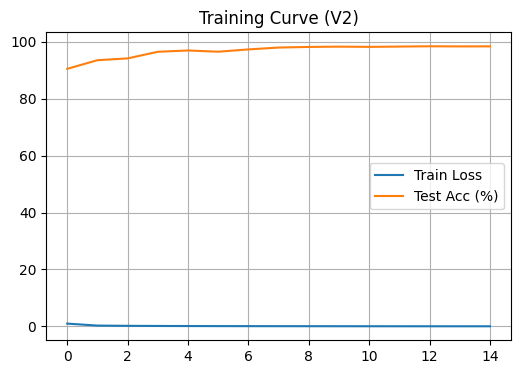

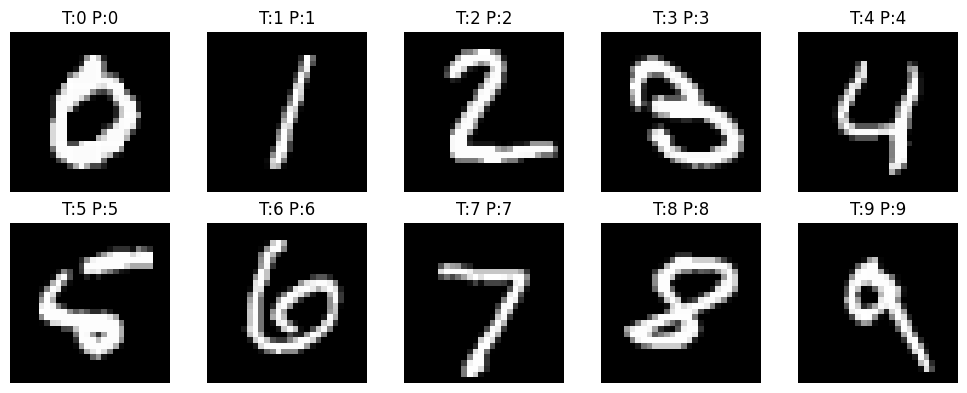

In [2]:
# ============================================================
# Lab7 – Manual LSTM Cell for MNIST | Version-2 (Tuned)
# ============================================================

import torch, torch.nn as nn, torch.optim as optim
import torchvision, torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np, random, os, math

# reproducibility
SEED = 2025
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

# ---------------- Hyper-parameters (Tuned) -------------------
input_size   = 28
hidden_size  = 256
num_layers   = 1
num_classes  = 10
batch_size   = 256
learning_rate= 0.0005
weight_decay = 1e-4
num_epochs   = 15
grad_clip    = 1.0

# ---------------- Data -------------------
transform = T.ToTensor()
train_ds = torchvision.datasets.MNIST('./data', train=True,  transform=transform, download=True)
test_ds  = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True,
                                           num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size, shuffle=False,
                                           num_workers=4, pin_memory=True)

# ---------------- Manual LSTM Cell ---------------------------
class ManualLSTMCell(nn.Module):
    def __init__(self, in_dim, hid_dim):
        super().__init__()
        self.x2h = nn.Linear(in_dim , 4*hid_dim, bias=True)
        self.h2h = nn.Linear(hid_dim, 4*hid_dim, bias=True)
        # Xavier 初始化以利收斂
        for m in (self.x2h, self.h2h):
            nn.init.xavier_uniform_(m.weight)

    def forward(self, x_t, h_pre, c_pre):
        gates = self.x2h(x_t) + self.h2h(h_pre)
        i, f, o, g = gates.chunk(4, dim=1)
        i, f, o = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o)
        g       = torch.tanh(g)
        c_t = f * c_pre + i * g
        h_t = o * torch.tanh(c_t)
        return h_t, c_t

# ---------------- Classifier ---------------------------
class ManualLSTMClassifier(nn.Module):
    def __init__(self, in_dim, hid_dim, n_cls, dropout=0.2):
        super().__init__()
        self.cell = ManualLSTMCell(in_dim, hid_dim)
        self.fc   = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hid_dim, n_cls)
        )

    def forward(self, x):                    # x : (B,28,28)
        B, seq, _ = x.size()
        h = torch.zeros(B, hidden_size, device=x.device)
        c = torch.zeros(B, hidden_size, device=x.device)
        for t in range(seq):                 # 28 time-steps
            h, c = self.cell(x[:, t, :], h, c)
        return self.fc(h)                    # logits

# Instantiate
model = ManualLSTMClassifier(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                        weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# ---------------- Training ---------------------------
train_losses, test_accs = [], []
for epoch in range(1, num_epochs+1):
    model.train()
    running = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.squeeze(1).to(device)      # (B,28,28)
        labels = labels.to(device)

        logits = model(imgs)
        loss   = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        running += loss.item() * imgs.size(0)

    scheduler.step()
    train_losses.append(running / len(train_loader.dataset))

    # -------- Test --------
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.squeeze(1).to(device), labels.to(device)
            pred = model(imgs).argmax(1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    acc = 100 * correct / total
    test_accs.append(acc)

    print(f'Epoch {epoch:2d}/{num_epochs} | Loss {train_losses[-1]:.4f} | '
          f'Test Acc {acc:.2f}% | lr {scheduler.get_last_lr()[0]:.2e}')

# ---------------- Visualization ---------------------------
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_accs, label='Test Acc (%)')
plt.legend(); plt.title('Training Curve (V2)'); plt.grid()
plt.show()

# -------- Show 10 examples -------------
model.eval()
seen = {k: False for k in range(10)}
fig, ax = plt.subplots(2,5, figsize=(10,4))
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs_cpu = imgs.clone()
        imgs = imgs.squeeze(1).to(device)
        preds = model(imgs).argmax(1).cpu()
        for img, lbl, pred in zip(imgs_cpu, labels, preds):
            d = int(lbl)
            if not seen[d]:
                idx = (d//5, d%5)
                ax[idx].imshow(img.squeeze(), cmap='gray')
                ax[idx].set_title(f"T:{d} P:{pred.item()}")
                ax[idx].axis('off')
                seen[d] = True
            if all(seen.values()):
                break
        if all(seen.values()):
            break
plt.tight_layout(); plt.show()
